In [1]:
import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

cell_geo = pd.read_pickle("./dataframes/cell_geometry")
cell = geopandas.GeoDataFrame(cell_geo, columns=['geometry'], 
                                 crs='epsg:4326')
linear_interpolation_log = pd.read_pickle("./dataframes/linear_interpolation_log")

In [2]:
jsonfile = ('/Users/christopher/Downloads/ark28722-s73w23-geojson.json')
world = geopandas.read_file(jsonfile)
import matplotlib.colors as colors

def plotter(dataset):
    cell["interpolated_value"] = dataset
    ax = cell.plot(column='interpolated_value', figsize=(8, 8), cmap='plasma', legend=True)
    world.to_crs(cell.crs).plot(ax = ax, color = "none", edgecolor = 'black', figsize = (8,8))
    return ax
def log_plotter(dataset):
    cell["interpolated_value"] = dataset
    ax = cell.plot(column='interpolated_value', figsize=(8, 8), cmap='plasma', norm=colors.SymLogNorm(vmin=cell["interpolated_value"].min(), vmax=cell["interpolated_value"].max(), linthresh = 0.02), legend=True)
    world.to_crs(cell.crs).plot(ax = ax, color = "none", edgecolor = 'black', figsize = (8,8))


In [3]:
jsonfile = ('./mygeodata/fire_station_point.geojson')
fire_station_points = geopandas.read_file(jsonfile)

In [4]:
len(fire_station_points)

1143

In [5]:
cell["interpolated_value"] = linear_interpolation_log

<IPython.core.display.Javascript object>


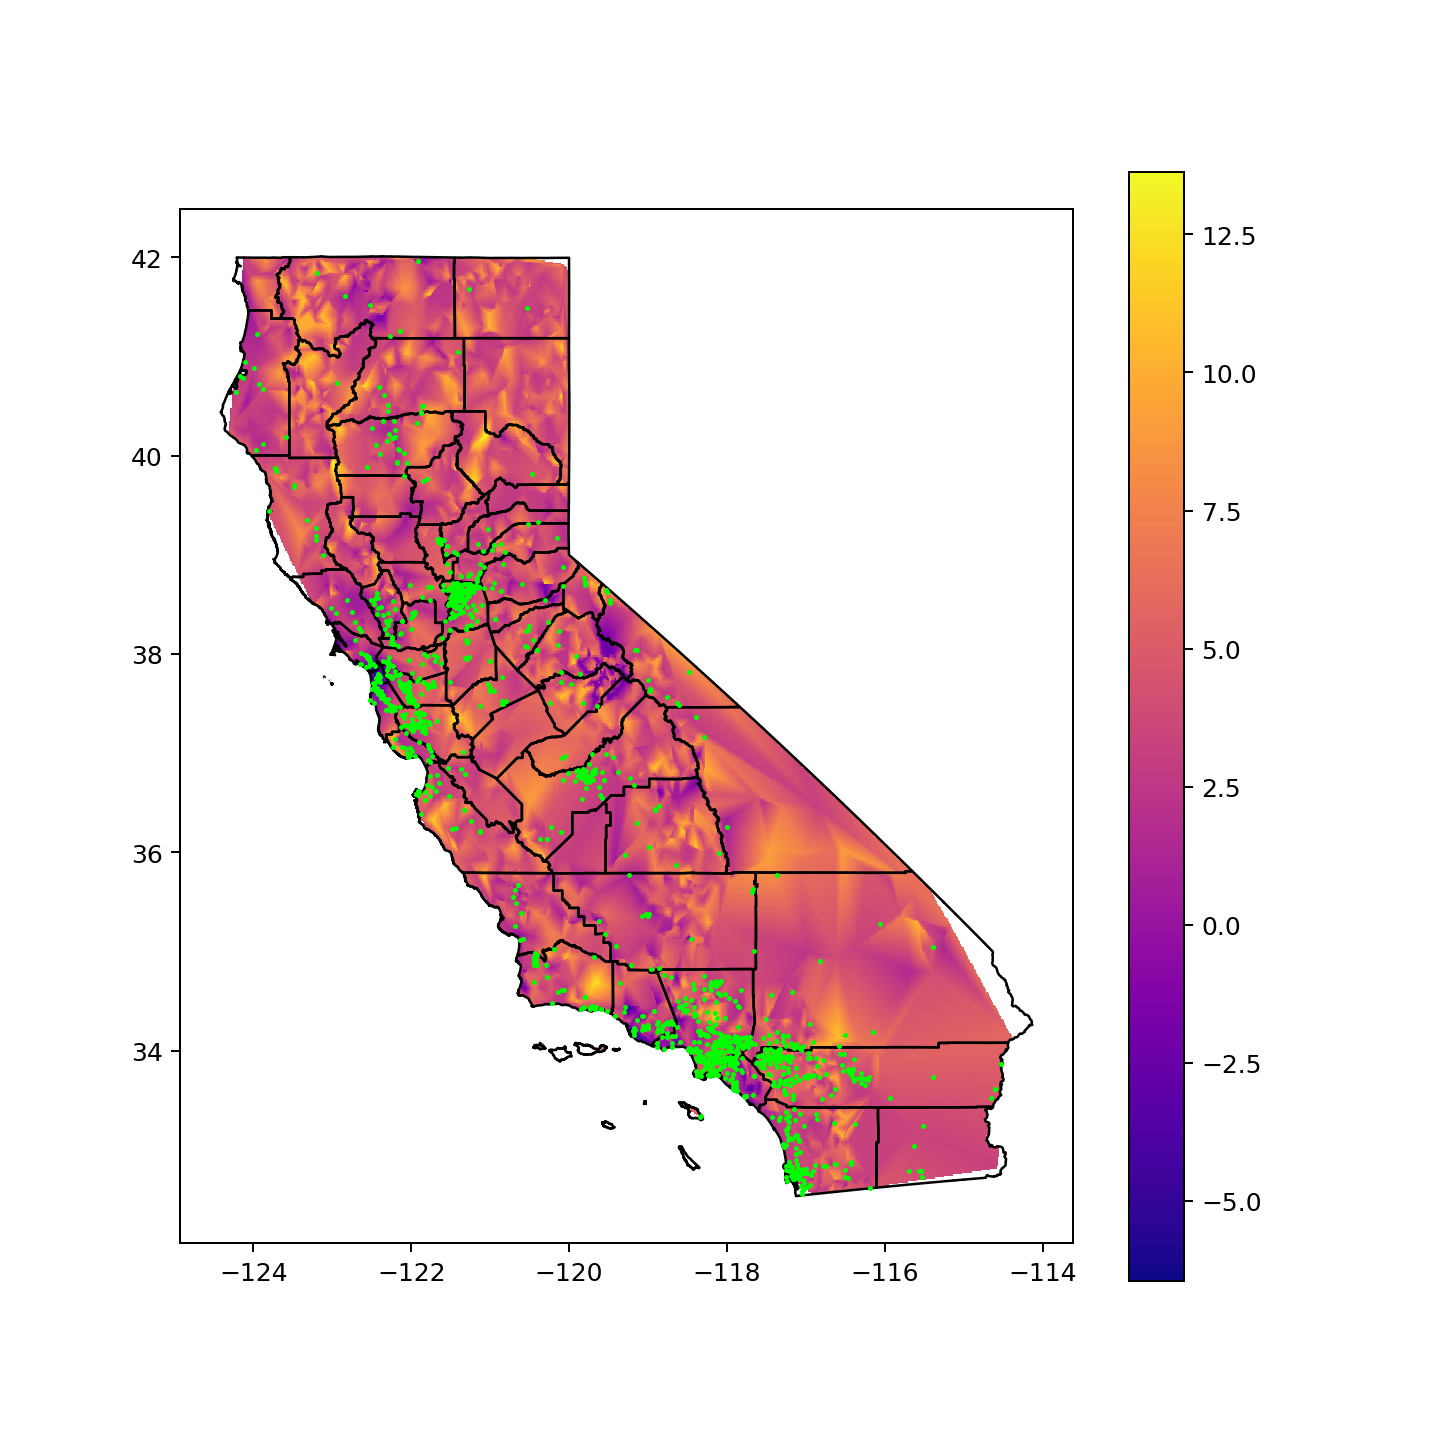

In [240]:
%matplotlib notebook

ax = plotter(cell["interpolated_value"])
plt.scatter(fire_station_points["geometry"].x, fire_station_points["geometry"].y, s = 1, color="lime")

<IPython.core.display.Javascript object>


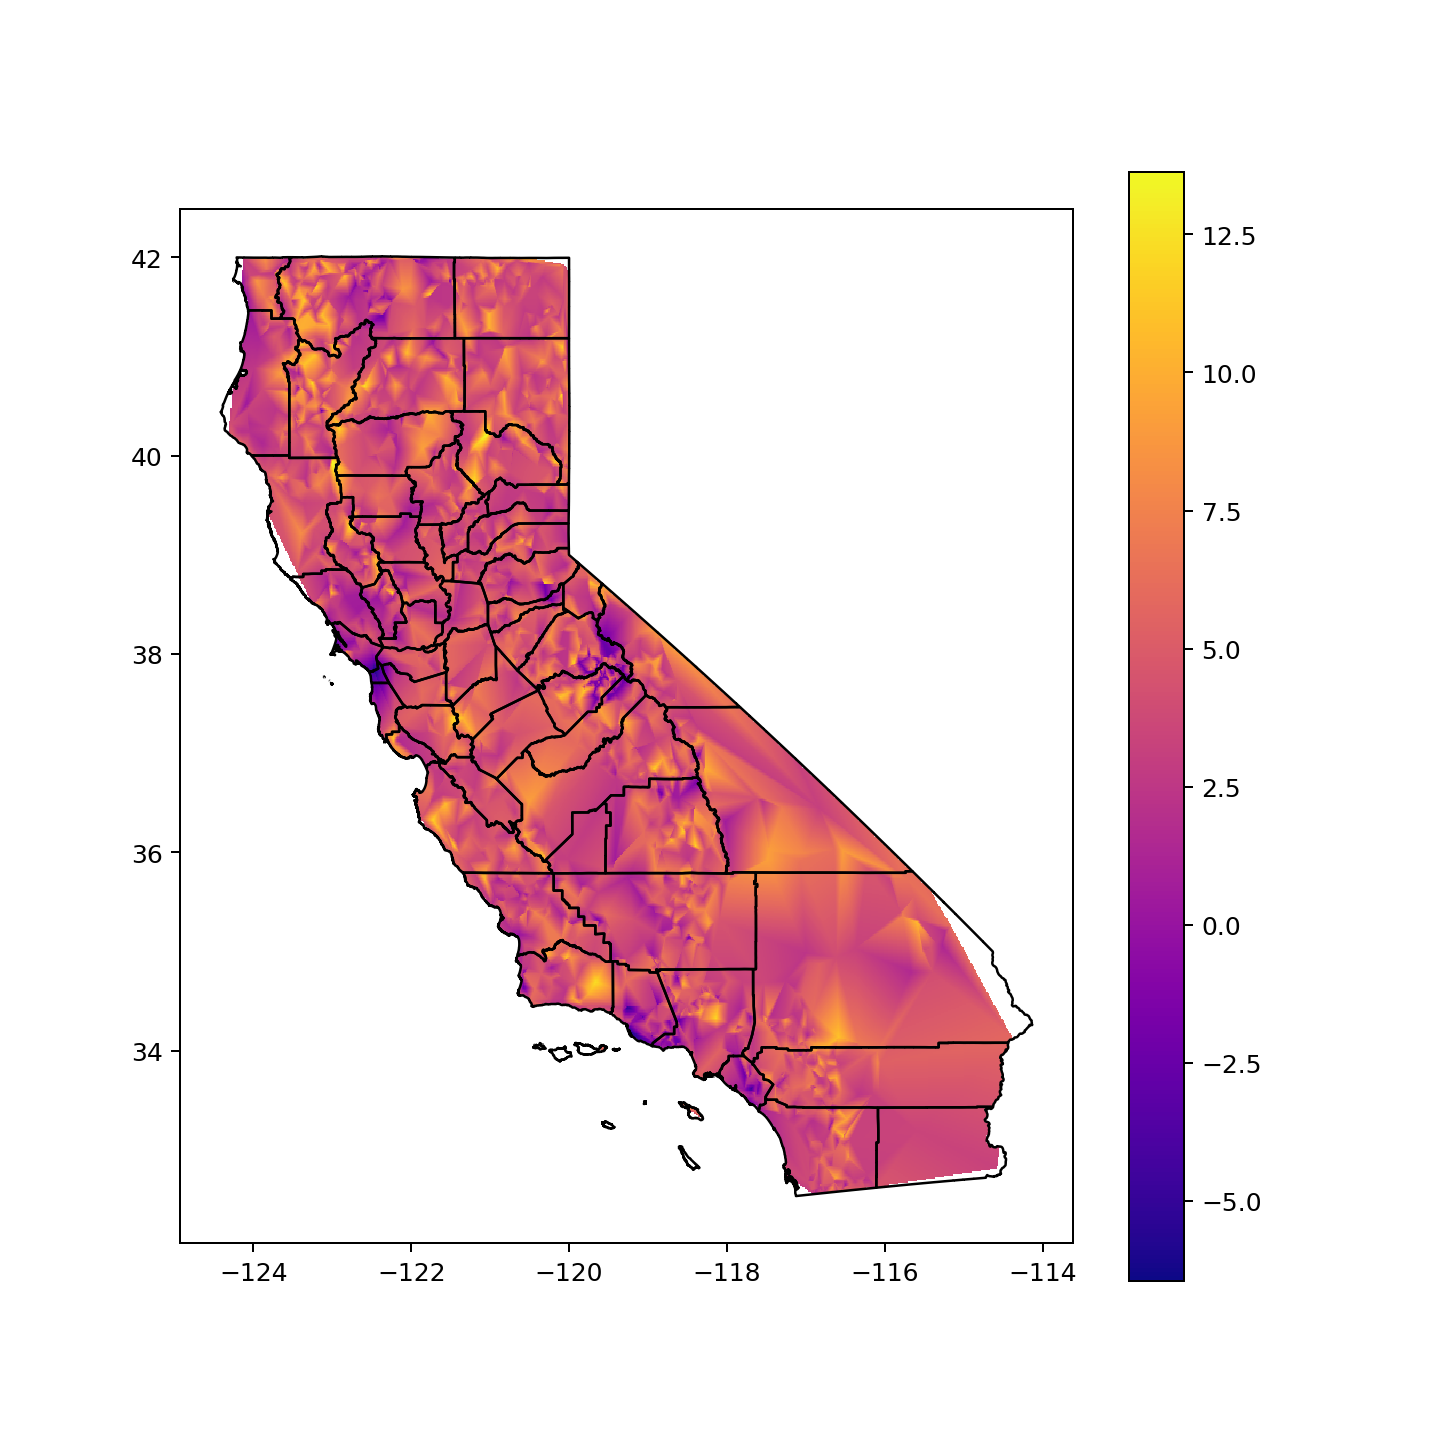

In [220]:
%matplotlib notebook
ax = plotter(linear_interpolation_log)
plt.scatter(fire_station_points["geometry"].x, fire_station_points.["geometry"].y, s = 1, color="lime")


In [6]:
cell_bounds = {}
for j in cell.index:
    cell_bounds[j] = cell["geometry"][j].bounds

In [9]:
positions_cell = [(int((cell["geometry"][i].centroid.x+125)*n_cells/12), int((cell["geometry"][i].centroid.y-32)*n_cells/12)) for i in cell.index]
cell["position"] = positions_cell
cell = cell.sort_values(by=["position"])

In [8]:
n_cells=828
cell_size = (12)/n_cells
positions_fs = [(int((fire_station_points["geometry"][i].x+125)*n_cells/12), fire_station_points["geometry"][i].y) for i in fire_station_points.index]
fire_station_points["position"] = positions_fs
fire_station_points = fire_station_points.sort_values(by=["position"])

In [10]:
ind = {}
indj = 0
j = cell.index[indj]
for i in tqdm(fire_station_points.index):
    xc = fire_station_points["geometry"][i].x
    yc = fire_station_points["geometry"][i].y
#     print("\n", i, xc, yc)
#     print(fire_station_points["position"][i][0], fire_station_points["position"][i][1])
    
    start = indj
    broken = False
    while not(cell_bounds[j][0] <= xc and cell_bounds[j][1] <= yc and cell_bounds[j][2] >= xc and cell_bounds[j][3] >= yc):
        indj += 1
        j = cell.index[indj]
#         if (i == 375 or i == 589):
#             print(indj, cell["position"][j], cell_bounds[j])
        
        if (cell["position"][j][0] > fire_station_points["position"][i][0]):
            indj = start
            j = cell.index[indj]
            broken = True
#             print("break")
            break
#     print("newline")
    if (broken):
        ind[i] = np.nan
#         print("WHATT")
    else:
        ind[i] = j
#     if (i == 1137):
#         break
#     break

  0%|          | 0/1143 [00:00<?, ?it/s]

In [11]:
ind

{402: 41636,
 1142: 44687,
 375: 46965,
 589: 48497,
 40: 53812,
 60: 55275,
 1141: 55356,
 386: 56841,
 1137: 59840,
 376: 59878,
 300: 63593,
 397: 68181,
 89: 68183,
 14: 75044,
 394: 80330,
 393: 80331,
 75: 88666,
 968: 94733,
 95: 94735,
 1135: 94741,
 917: 95679,
 62: 99283,
 1124: 105326,
 1123: 108362,
 1004: 109282,
 61: 114663,
 1126: 115211,
 905: 118242,
 1120: 121263,
 1122: 121276,
 268: 123552,
 946: 124287,
 945: 125047,
 1012: 125054,
 247: 125070,
 203: 127332,
 610: 128084,
 754: 128093,
 753: 128851,
 755: 128852,
 649: 128984,
 929: 130365,
 596: 130366,
 1108: 130368,
 392: 130369,
 118: 130372,
 657: 131101,
 162: 131171,
 348: 131377,
 235: 132629,
 1103: 132633,
 264: 132647,
 31: 132811,
 1099: 133379,
 1102: 133390,
 944: 133448,
 174: 133451,
 855: 134154,
 1106: 134165,
 908: 134908,
 233: 134910,
 853: 134916,
 25: 134973,
 663: 135079,
 854: 135675,
 1104: 135676,
 182: 135722,
 757: 135725,
 658: 135736,
 594: 136425,
 907: 136428,
 856: 136439,
 140: 1

In [12]:
null_firestations = []
for x in ind.keys():
    if (ind[x] is np.nan):
        null_firestations.append(x)

In [13]:
fire_station_points = fire_station_points[[(not (i in null_firestations)) for i in fire_station_points.index]]

In [14]:
import shapely.geometry
n_cells=828
cell_size = (12)/n_cells
cell["interpolated_value"] = linear_interpolation_log
max_score = 0
max_info = ()
all_coverages = []
for i in tqdm(fire_station_points.index):

    pos = ind[i]
    score = 0
    for row in range(5):
        for column in range(5):
            new_ind = pos+column+row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    if (score > max_score):
        max_score = score
        max_info = (cell["geometry"][pos], 1)
    all_coverages.append((score, pos, 1, i))
        
        
    score = 0
    for row in range(5):
        for column in range(5):
            new_ind = pos-column+row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    if (score > max_score):
        max_score = score
        max_info = (cell["geometry"][pos], 2)
    all_coverages.append((score, pos, 2, i))
        
        
    score = 0
    for row in range(5):
        for column in range(5):
            new_ind = pos-column-row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    if (score > max_score):
        max_score = score
        max_info = (cell["geometry"][pos], 3)
    all_coverages.append((score, pos, 3, i))

    
    score = 0
    for row in range(5):
        for column in range(5):
            new_ind = pos+column-row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    if (score > max_score):
        max_score = score
        max_info = (cell["geometry"][pos], 4)
    all_coverages.append((score, pos, 4, i))
        
        
    score = 0
    for row in range(-2, 3):
        for column in range(5):
            new_ind = pos+column+row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    if (score > max_score):
        max_score = score
        max_info = (cell["geometry"][pos], 5)
    all_coverages.append((score, pos, 5, i))
        
        
    score = 0
    for row in range(-2, 3):
        for column in range(5):
            new_ind = pos-column+row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    if (score > max_score):
        max_score = score
        max_info = (cell["geometry"][pos], 6)
    all_coverages.append((score, pos, 6, i))
        
        
    score = 0
    for row in range(5):
        for column in range(-2, 3):
            new_ind = pos+column-row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    if (score > max_score):
        max_score = score
        max_info = (cell["geometry"][pos], 7)
    all_coverages.append((score, pos, 7, i))
    
    
    score = 0
    for row in range(5):
        for column in range(-2, 3):
            new_ind = pos+column+row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    if (score > max_score):
        max_score = score
        max_info = (cell["geometry"][pos], 8)
    all_coverages.append((score, pos, 8, i))
        
        
    score = 0
    for row in range(-2, 3):
        for column in range(-2, 3):
            new_ind = pos+column-row*760
            if new_ind in cell.index:
                score += cell["interpolated_value"][new_ind]
    if (score > max_score):
        max_score = score
        max_info = (cell["geometry"][pos], 9)
    all_coverages.append((score, pos, 9, i))
#                 cell.at[new_ind, "interpolated_value"] = 20
                
    
    
    
#     polygon11 = shapely.geometry.Polygon(
#     [
#         (minx - 4.5*cell_size, maxy + 0.5*cell_size),
#         (maxx + 0.5*cell_size, maxy + 0.5*cell_size),
#         (minx - 4.5*cell_size, miny - 4.5*cell_size),
#         (maxx + 0.5*cell_size, miny - 4.5*cell_size)
#     ])
    
#     polygon12 = shapely.geometry.Polygon(
#     [
#         (minx - 4.5*cell_size, maxy + 4.5*cell_size),
#         (maxx + 0.5*cell_size, maxy + 4.5*cell_size),
#         (minx - 4.5*cell_size, miny - 0.5*cell_size),
#         (maxx + 0.5*cell_size, miny - 0.5*cell_size)
#     ])
    
#     polygon13 = shapely.geometry.Polygon(
#     [
#         (minx - 0.5*cell_size, maxy + 4.5*cell_size),
#         (maxx + 4.5*cell_size, maxy + 4.5*cell_size),
#         (minx - 0.5*cell_size, miny - 0.5*cell_size),
#         (maxx + 4.5*cell_size, miny - 0.5*cell_size)
#     ])
    
#     polygon14 = shapely.geometry.Polygon(
#     [
#         (minx - 0.5*cell_size, maxy + 0.5*cell_size),
#         (maxx + 4.5*cell_size, maxy + 0.5*cell_size),
#         (minx - 0.5*cell_size, miny - 4.5*cell_size),
#         (maxx + 4.5*cell_size, miny - 4.5*cell_size)
#     ])
    
    
    
    
#     polygon21 = shapely.geometry.Polygon(
#     [
#         (minx - 2.5*cell_size, maxy + 4.5*cell_size),
#         (maxx + 2.5*cell_size, maxy + 4.5*cell_size),
#         (minx - 2.5*cell_size, miny - 0.5*cell_size),
#         (maxx + 2.5*cell_size, miny - 0.5*cell_size)
#     ])
    
#     polygon22 = shapely.geometry.Polygon(
#     [
#         (minx - 2.5*cell_size, maxy + 0.5*cell_size),
#         (maxx + 2.5*cell_size, maxy + 0.5*cell_size),
#         (minx - 2.5*cell_size, miny - 4.5*cell_size),
#         (maxx + 2.5*cell_size, miny - 4.5*cell_size)
#     ])
    
#     polygon23 = shapely.geometry.Polygon(
#     [
#         (minx - 0.5*cell_size, maxy + 2.5*cell_size),
#         (maxx + 4.5*cell_size, maxy + 2.5*cell_size),
#         (minx - 0.5*cell_size, miny - 2.5*cell_size),
#         (maxx + 4.5*cell_size, miny - 2.5*cell_size)
#     ])
    
#     polygon24 = shapely.geometry.Polygon(
#     [
#         (minx - 4.5*cell_size, maxy + 2.5*cell_size),
#         (maxx + 0.5*cell_size, maxy + 2.5*cell_size),
#         (minx - 4.5*cell_size, miny - 2.5*cell_size),
#         (maxx + 0.5*cell_size, miny - 2.5*cell_size)
#     ])
    
    
    
    
#     polygon31 = shapely.geometry.Polygon(
#     [
#         (minx - 2.5*cell_size, maxy + 2.5*cell_size),
#         (maxx + 2.5*cell_size, maxy + 2.5*cell_size),
#         (minx - 2.5*cell_size, miny - 2.5*cell_size),
#         (maxx + 2.5*cell_size, miny - 2.5*cell_size)
#     ])
    
    
    
#     polygons = [polygon11, polygon12, polygon13, polygon14, polygon21, polygon22, polygon23, polygon24, polygon31]
#     polygon_count = 0
#     for polygon in polygons:
#         score = 0
#         polygon_count += 1
#         for cellnum in cell.index:
#             if (cell["geometry"][cellnum].within(polygon)):
#                 score += cell["interpolated_value"][cellnum]
#         if (score > max_score):
#             max_score = score
#             max_info = (i, polygon_count)
print(max_score, max_info)

  0%|          | 0/1142 [00:00<?, ?it/s]

268.57924128832565 (<POLYGON ((-118.159 34.391, -118.145 34.391, -118.145 34.377, -118.159 34.37...>, 6)


In [15]:
all_coverages.sort()
all_coverages.reverse()

In [16]:
all_coverages

[(268.57924128832565, 361160, 4, 601),
 (268.57924128832565, 359644, 6, 609),
 (261.9506607578624, 361160, 7, 601),
 (259.37673008342904, 361160, 5, 601),
 (259.37673008342904, 359644, 2, 609),
 (254.21693975026892, 359644, 9, 609),
 (253.790530608966, 361160, 9, 601),
 (253.26435462657972, 359644, 3, 609),
 (248.5869790572973, 359644, 8, 609),
 (245.23359117229663, 446268, 7, 653),
 (239.1122859417104, 359644, 7, 609),
 (237.67711228238235, 359644, 5, 609),
 (236.8952472551897, 359644, 1, 609),
 (231.93696448958963, 273775, 1, 573),
 (231.93696448958963, 273775, 1, 572),
 (231.93696448958963, 273775, 1, 299),
 (231.93696448958963, 273775, 1, 298),
 (231.6468569676423, 147794, 4, 400),
 (225.89192585205993, 267172, 3, 121),
 (225.88752088234187, 359636, 5, 130),
 (225.88752088234185, 361160, 3, 601),
 (223.9472055051532, 361160, 1, 601),
 (223.02500372042365, 355837, 1, 36),
 (221.80931793796623, 359644, 4, 609),
 (221.35866025494784, 361160, 8, 601),
 (220.96748184628913, 424223, 2, 1

In [17]:
top_coverages = all_coverages[:100]
choose = [x[3] for x in top_coverages]

In [300]:
top_coverages

[(268.57924128832565, 361160, 4, 601),
 (268.57924128832565, 359644, 6, 609),
 (261.9506607578624, 361160, 7, 601),
 (259.37673008342904, 361160, 5, 601),
 (259.37673008342904, 359644, 2, 609),
 (254.21693975026892, 359644, 9, 609),
 (253.790530608966, 361160, 9, 601),
 (253.26435462657972, 359644, 3, 609),
 (248.5869790572973, 359644, 8, 609),
 (245.23359117229663, 446268, 7, 653),
 (239.1122859417104, 359644, 7, 609),
 (237.67711228238235, 359644, 5, 609),
 (236.8952472551897, 359644, 1, 609),
 (231.93696448958963, 273775, 1, 573),
 (231.93696448958963, 273775, 1, 572),
 (231.93696448958963, 273775, 1, 299),
 (231.93696448958963, 273775, 1, 298),
 (231.6468569676423, 147794, 4, 400),
 (225.89192585205993, 267172, 3, 121),
 (225.88752088234187, 359636, 5, 130),
 (225.88752088234185, 361160, 3, 601),
 (223.9472055051532, 361160, 1, 601),
 (223.02500372042365, 355837, 1, 36),
 (221.80931793796623, 359644, 4, 609),
 (221.35866025494784, 361160, 8, 601),
 (220.96748184628913, 424223, 2, 1

In [301]:
# %matplotlib notebook

# ax = plotter(cell["interpolated_value"])
# plt.scatter(cell["geometry"][362684].centroid.x, cell["geometry"][362684].centroid.y, s = 1, color="lime")
# plt.scatter(cell["geometry"][362685].centroid.x, cell["geometry"][362685].centroid.y, s = 1, color="red")
# plt.scatter(cell["geometry"][362684+760].centroid.x, cell["geometry"][362684+760].centroid.y, s = 1, color="lime")


<IPython.core.display.Javascript object>


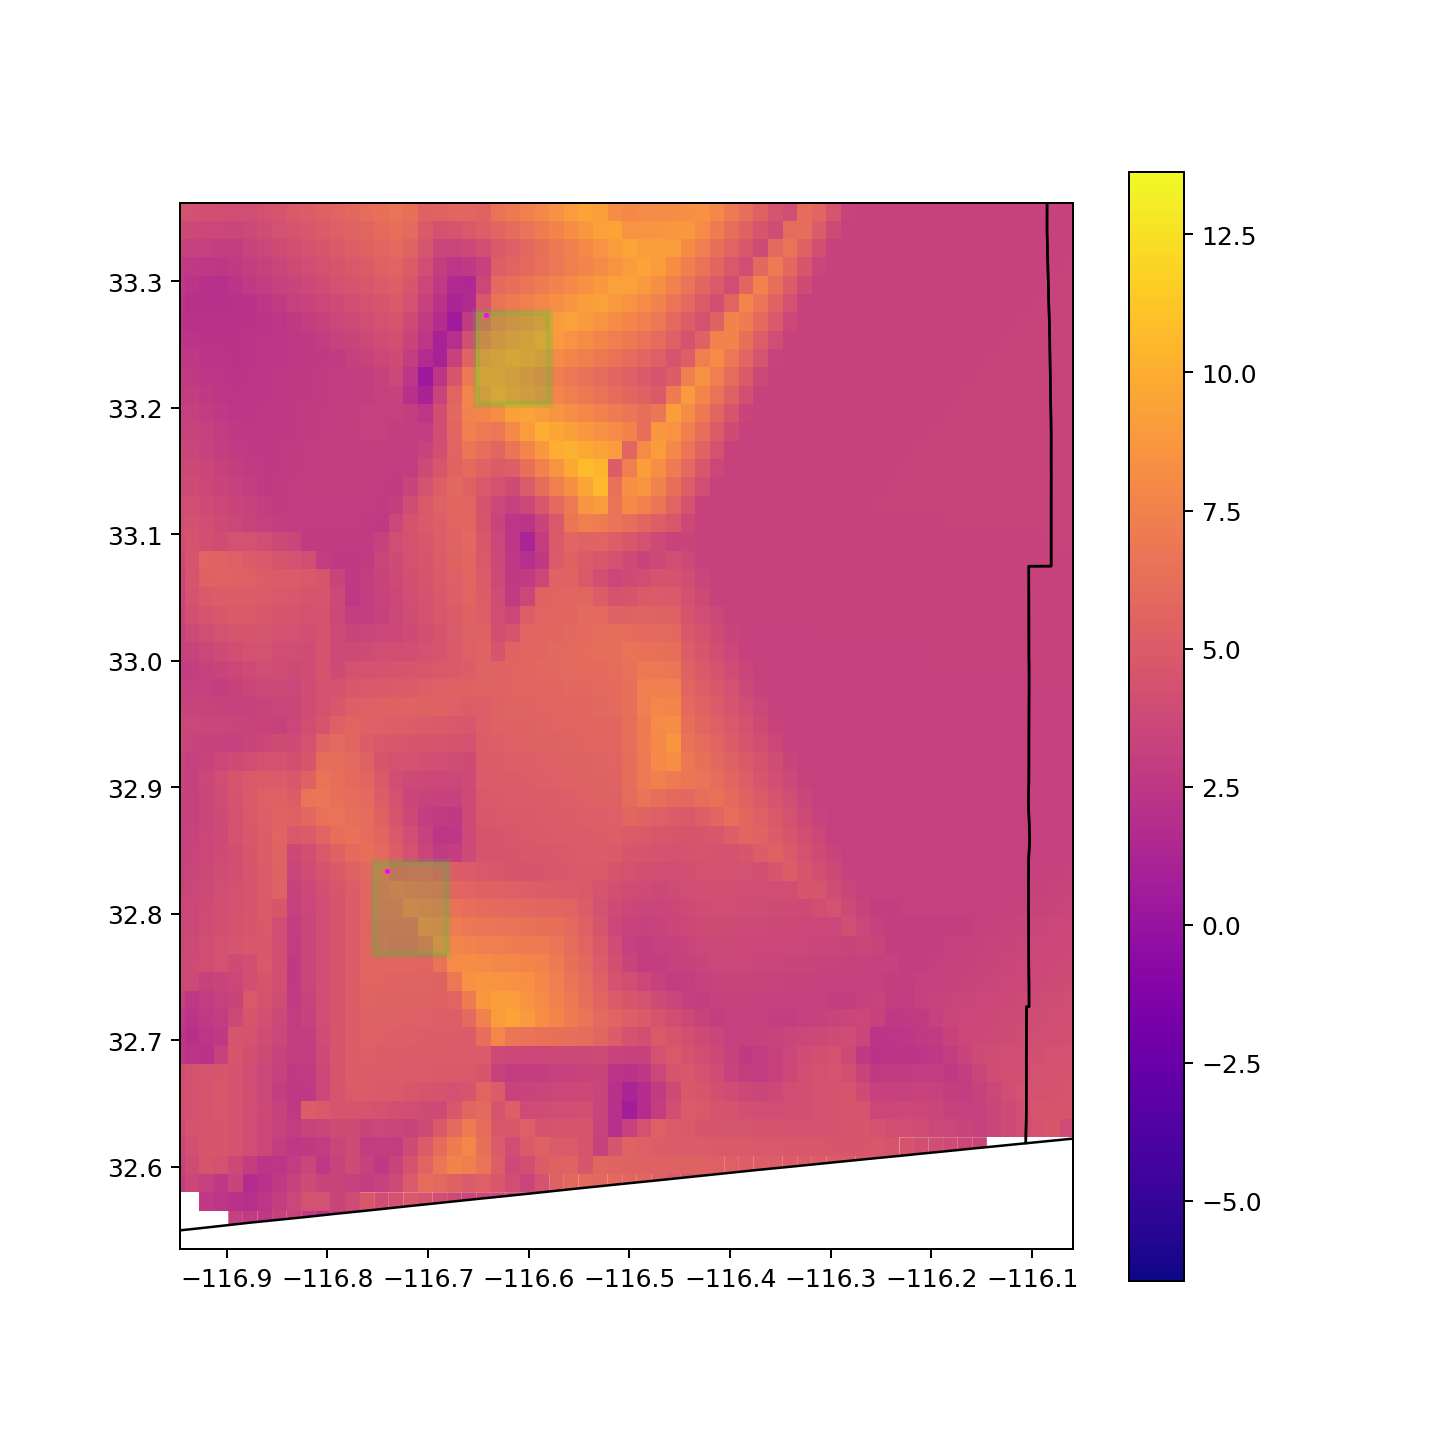

In [20]:
%matplotlib notebook

ax = plotter(cell["interpolated_value"])
for x in top_coverages:
    indx = x[1]
    minx, miny, maxx, maxy = cell["geometry"][indx].bounds
    if (x[2] == 1):
        pos = (minx, miny)
    if (x[2] == 2):
        pos = (minx, maxy-5*12/n_cells)
    if (x[2] == 3):
        pos = (maxx-5*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 4):
        pos = (maxx-5*12/n_cells, miny)
    if (x[2] == 5):
        pos = (minx-2*12/n_cells, miny)
    if (x[2] == 6):
        pos = (minx-2*12/n_cells, maxy-5*12/n_cells)
    if (x[2] == 7):
        pos = (maxx-5*12/n_cells, miny-2*12/n_cells)
    if (x[2] == 8):
        pos = (minx, miny-2*12/n_cells)
    if (x[2] == 9):
        pos = (minx-2*12/n_cells, miny-2*12/n_cells)
    rect = plt.Rectangle(pos, 5*12/n_cells, 5*12/n_cells, color="limegreen", linewidth=3, alpha = 0.2)
    ax = ax or plt.gca()
    ax.add_patch(rect)
plt.scatter(fire_station_points["geometry"][choose].x, fire_station_points["geometry"][choose].y, s = 1, color="magenta")